# 95-891 Homework 3 – Computer Vision
Due March 17th, 2022

In this homework, we will implement [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks)-like deep, convolutional neural network (CNN) with PyTorch. We are going to use the CNN to classify flowers into the 102 categories.

The homework consists of the following parts:

- Load and prepare data.
- Load a pretrained Alexnet in PyTorch.
- Set up transfer learning for flower classification problem
- Train the model
- Model performance monitoring and analysis with learning curve
- Questions regarding the design choices

## The places requiring an input are marked with "???".

#### 1.1. Load the dataset which are in three folders, namely train, validation, and test

In [1]:
import matplotlib.pyplot as plt
from collections import OrderedDict

from copy import deepcopy
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models

# download the data and unzip it. You should have three sets of data
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'


#### 1.2. Preview some images
Use PIL library to preview images

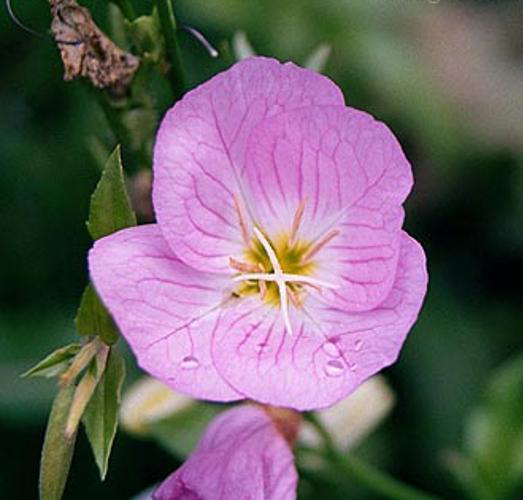

In [2]:
from PIL import Image  #show one example of image

Image.open("flowers/train/1/image_06734.jpg")

#### 1.3. Data transformation and processing

In [3]:
# Process with some data transformation, do not change
data_transforms = {
    'training': transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(30),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224,
                                                          0.225])]),

    'validation': transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          [0.485, 0.456, 0.406],
                                          [0.229, 0.224, 0.225])]),

    'testing': transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224,
                                                         0.225])])
}
# This decides how many images to process per training/validation
batch_size = 256

image_datasets = {
    'training': datasets.ImageFolder(train_dir,
                                     transform=data_transforms['training']),
    'testing': datasets.ImageFolder(test_dir,
                                    transform=data_transforms['testing']),
    'validation': datasets.ImageFolder(valid_dir,
                                       transform=data_transforms['validation'])
}

dataloaders = {
    'training': torch.utils.data.DataLoader(image_datasets['training'],
                                            batch_size=batch_size,
                                            shuffle=True),
    'testing': torch.utils.data.DataLoader(image_datasets['testing'],
                                           batch_size=batch_size,
                                           shuffle=False),
    'validation': torch.utils.data.DataLoader(image_datasets['validation'],
                                              batch_size=batch_size,
                                              shuffle=True)
}

# get the length of each dataloaders; wit batch size=256, you should have 26 batches of training samples, each with 256 images
training_len = len(dataloaders['training'])
test_len = len(dataloaders['testing'])
validation_len = len(dataloaders['validation'])
class_to_idx = image_datasets['training'].class_to_idx

print('We have ', training_len, 'batches of training images;', 'each with',
      batch_size, 'images')
print('We have ', validation_len, 'batches of validation images;', 'each with',
      batch_size, 'images')

# Let us preview size of each batch
print('Single batch', next(iter(dataloaders['training']))[0].shape)

We have  26 batches of training images; each with 256 images
We have  4 batches of validation images; each with 256 images
Single batch torch.Size([256, 3, 224, 224])


### *Question 1: What is the effect of random flip and rotation in image data transformation?*
- How does it impact the training?
#### - a random flip and rotation acts as a way to increase the number of training examples without having to get additional samples.  Here, an image of a flower when flipped or rotated is still an image of a flower, just from a new perspective.  This will help the model generalize better.
- Why do not we apply them randomly at the validation or test time?
#### - At test time, we want to find the label for the image in question, there is no need to classify additional images viewed in a different way.

### *Question 2: Explain the meaning of these numbers for a single batch?*
- 256:
#### - the size of the batch, that is, there are 256 images in one batch from the dataloader
- 3:
#### - the number of channels in the image, that is, there are 3 channels per image
- 224:
#### - the number of horizonal pixels in the image, that is, the image is 224 pixels wide
- 224:
#### - the number of vertical pixels in the image, that is, the image is 224 pixels tall

#### 1.4. Initialize the pretrained model

We are going to use an Alexnet convolutional neural network as our pretrained model. The architecture of the network is shown below
![picture](https://drive.google.com/uc?export=view&id=1XG8ZPxxcaOTaniTm-s_FdK4iRJbdMkhA)

Image credit: https://neurohive.io/en/popular-networks/alexnet-imagenet-classification-with-deep-convolutional-neural-networks/

In [4]:
# Transfer learning with alexnet
model = models.alexnet(pretrained=True)

### 1.5. Update the classifier of the model to be compatible with our datasets

In [5]:
# In transfer learning, we freeze the feature parameters from the original model
# The most straightforward way is to freeze their gradient update
# see https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad.html for how to set it
for param in model.parameters():
    param.requires_grad = False

print(model)

# This is the original classifier with alexnet
print()
print('Original classifier of Alexnet')
print(model.classifier)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
# now we need to replace the classifier by our datasets
# Note, fc2's out_feature should match our number of classes, which is 102

# Tip: check the original AlexNet classifier for some thoughts; they are similar.

# Defining number of hidden units in our fully connected layer
hidden_units = 4096
number_of_flowers = len(class_to_idx)

# Defining the fully connected layer that will be trained on the flower images
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(9216, hidden_units)), # this should be a Linear layer; how to connect with the pretrained model?
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.5)),
    ('fc2', nn.Linear(hidden_units, 102)), # what is the output of this layer should be
    ('output', nn.LogSoftmax(dim=1))
]))


### *Question 3: Why are we using the Dropout layer in neural networks as shown above?*
- Explain it is usage briefly.
#### - Dropout layers are used to ignore some nodes within the layer.  for example, when training, with a dropout layer with 50% dropout, we would take a random 50% of the nodes within the layer zero their outputs before passing the information on to the next layer
- How does the dropout layer work during the prediction (evaluation) stage?
#### - The dropout layer during prediciton does not drop any node information.


In [7]:
# double check if the classifier of the model is updated.
model.classifier = classifier
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (fc1): Linear(in_features=9216, out_features=4096, bias=True)
    (relu): ReLU()
    (dropout): Drop

### 1.6. Set up the configurations and train it!
- epochs = 30
- since it is a multiclassification problem, we use [negative log likelihood loss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)
- we use the [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)
- learning rate (lr) = 0.001

In each epoch, we go through all the training samples to update the model, and evaluate with the validation samples to see how good the current model is.
- accuracy: mean of the matches in predicted class and the labels
- loss: negative log likelihood loss


**Sample outputs are provided below; but yours may vary**
**Your validation accuracy may be better than train; this is fine**

In [8]:
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 30
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
criterion = nn.NLLLoss() # this is the loss
print_every = 5

validation_accuracies, training_accuracies = [], []
validation_losses, training_losses = [], []

best_validation_accuracy = 0
best_model_weights = None

for e in range(epochs):

    training_loss = training_accuracy = 0
    validation_loss = validation_accuracy = 0

    model.train()
    for batch_idx, (images, labels) in enumerate(dataloaders['training']):

        # Moving images & labels to the GPU if there is one
        images, labels = images.to(device), labels.to(device)

        # Pushing batch through network, calculating loss & gradient, and updating weights
        log_ps = model.forward(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        # Calculating metrics
        ps = torch.exp(log_ps)
        top_ps, top_class = ps.topk(1, dim=1)
        matches = (top_class == labels.view(*top_class.shape)).type(
            torch.FloatTensor)
        train_batch_accuracy = matches.mean()

        # Resetting optimizer gradient & tracking metrics
        optimizer.zero_grad()
        training_loss += loss.item()
        train_batch_loss = loss.item()
        training_accuracy += train_batch_accuracy.item()

        if batch_idx % print_every == 0:
            # First analyze the training statistics
            print('epoch', e, 'batch', batch_idx)
            print('training loss per batch', train_batch_loss)
            print('training accuracy per batch', train_batch_accuracy.item())

    # Then do the analysis for the validation only at the end of each training epochs
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(
                dataloaders['validation']):
            images, labels = images.to(device), labels.to(device)
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            ps = torch.exp(log_ps)
            top_ps, top_class = ps.topk(1, dim=1)
            matches = (top_class == labels.view(*top_class.shape)).type(
                torch.FloatTensor)
            validation_batch_accuracy = matches.mean()

            # Tracking validation metrics
            validation_loss += loss.item()
            validation_batch_loss = loss.item()
            validation_accuracy += validation_batch_accuracy.item()

    # Save the best model weights so far
    # Tip: see this https://pytorch.org/tutorials/beginner/saving_loading_models.html
    if validation_accuracy >= best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        best_model_weights = copy.deepcopy(model.state_dict())

    # Summary statistic per epoch
    print()
    print('epoch', e, 'summary')
    print('avg training loss per epoch', training_loss / training_len)
    print('avg training accuracy per epoch', training_accuracy / training_len)
    training_losses.append(training_loss / training_len)
    training_accuracies.append(training_accuracy / training_len)

    print('avg validation loss per epoch', validation_loss / validation_len)
    print('avg validation accuracy per epoch',
          validation_accuracy / validation_len)
    validation_losses.append(validation_loss / validation_len)
    validation_accuracies.append(validation_accuracy / validation_len)

    print()

epoch 0 batch 0
training loss per batch 4.73652982711792
training accuracy per batch 0.01953125
epoch 0 batch 5
training loss per batch 16.368642807006836
training accuracy per batch 0.02734375
epoch 0 batch 10
training loss per batch 6.729473114013672
training accuracy per batch 0.09765625
epoch 0 batch 15
training loss per batch 3.7151312828063965
training accuracy per batch 0.14453125
epoch 0 batch 20
training loss per batch 3.2887825965881348
training accuracy per batch 0.23046875
epoch 0 batch 25
training loss per batch 2.9331467151641846
training accuracy per batch 0.25

epoch 0 summary
avg training loss per epoch 7.727766981491675
avg training accuracy per epoch 0.13551682692307693
avg validation loss per epoch 1.9756149351596832
avg validation accuracy per epoch 0.5010937452316284

epoch 1 batch 0
training loss per batch 2.607924699783325
training accuracy per batch 0.34375
epoch 1 batch 5
training loss per batch 2.3418033123016357
training accuracy per batch 0.37890625
epoch 1

### *Question 4: Report the best model's validation accuracy*


In [96]:
torch.save(best_model_weights, "./best_weights.pt") # save the weights so I dont have to re-train the model later
print(f'Best Validation Accuracy: {best_validation_accuracy / validation_len}%')

Best Validation Accuracy: 0.9057812541723251%


### 1.7. Draw learning curves

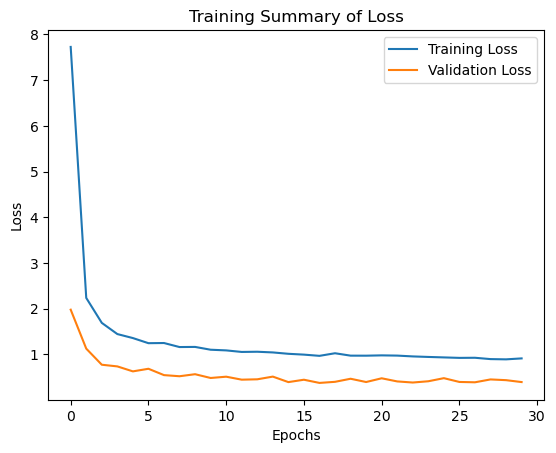

In [9]:
plt.figure()
plt.title("Training Summary of Loss")
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

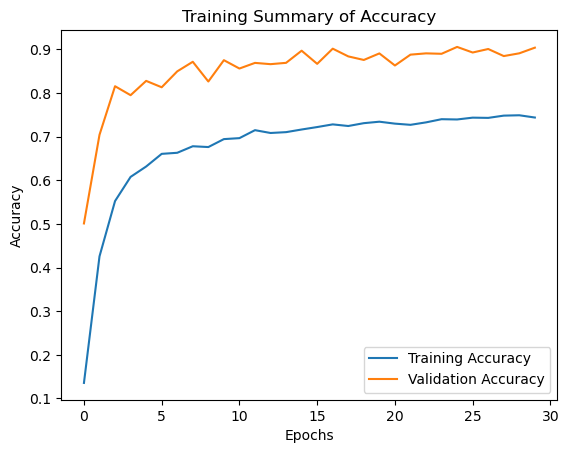

In [10]:
plt.figure()
plt.title("Training Summary of Accuracy")
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### *Question 5: Briefly describe the plots*
#### - The training summary of loss plot shows the loss value for the training and validation sets for each epoch.  It decreases for both indicating that the model is learning, and the loss is getting smaller over time.  The validation loss is decreasing even after 30 epochs, indicating that there is still room for improvement in the model without overfitting.
#### - The training summary of accuracy plot shows the accuracy of predictions for each epoch.  As one can see, it increases over time, indicating that the model is improving and becoming more accurate.  Since validation accuracy is still increasing, it indicates that there is still room for improvement in the model without overfitting.

### 1.8. Predict on the test data with the best model so far

In [10]:
# Predict on the test data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_model_weights = torch.load("./best_weights.pt")
# Load the best model so far
model.load_state_dict(best_model_weights)
test_accuracy = 0

predictions = []
label_data = []

model.to(device)
model.eval()
with torch.no_grad():
    for images, labels in dataloaders['testing']:
        images, labels = images.to(device), labels.to(device)
        log_ps = model(images)
        ps = torch.exp(log_ps)
        top_ps, top_class = ps.topk(1, dim=1)
        matches = (top_class == labels.view(*top_class.shape)).type(
            torch.FloatTensor)
        test_batch_accuracy = matches.mean()

        # Tracking metrics
        test_accuracy += test_batch_accuracy.item()

        predictions.extend(top_class.reshape(-1).cpu().numpy())
        label_data.extend(labels.cpu().numpy())
        # Try to do similar things as validation to get the test accuracy
        # You also need to store the predictions and labels for all the test data, which will be used later
        # you could save them in predictions and label_data
print('Test Accuracy:', test_accuracy / test_len)

Test Accuracy: 0.8415479511022568


### *Question 6: Report the test accuracy with the best model*

#### - The test accuracy is 84%

### *Question 7: Provide a confusion matrix between the ground truth and predicted labels in the test dataset. The rows should correspond to the ground truth categories and the columns to predicted categories. The confusion matrix here should have raw datapoint counts and should not be normalized as percentages*

### *Question 8: Now normalize the raw confusion matrix reported in the previous question by dividing each row by the sum of all its elements. Include this normalized confusion matrix in your report. It may look small but that is fine.*

### *Question 9: What does the diagonal denote in the normalized confusion matrix? What is the meaning of the number in the row 1 column 2?*
#### - the diagonal denotes the true positive values.  That is the percent of the time that the model correctly predicted the image.
#### - the meaning of row 1 column 2 is the percentage of ground truth label 0 that were incorrectly predicted as label 1.

First 10 classes confusion matrix


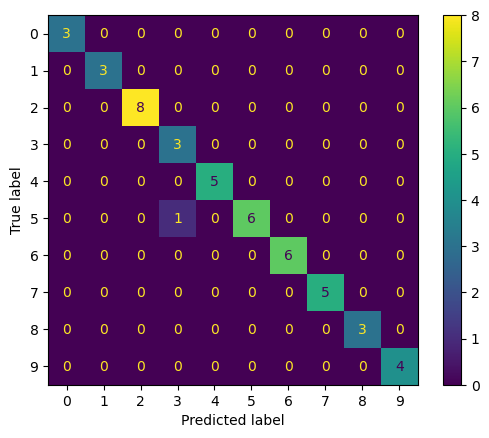

First 10 classes normalized confusion matrix


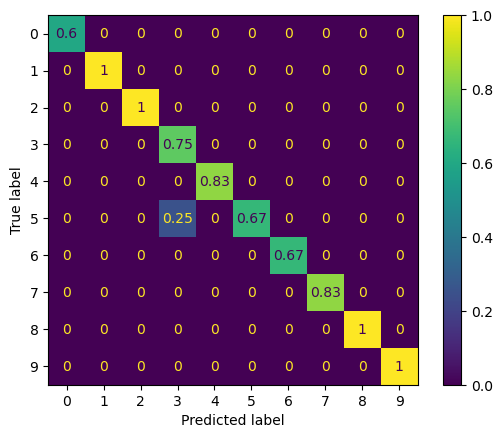

confusion matrix
[[3 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 8 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 6]]


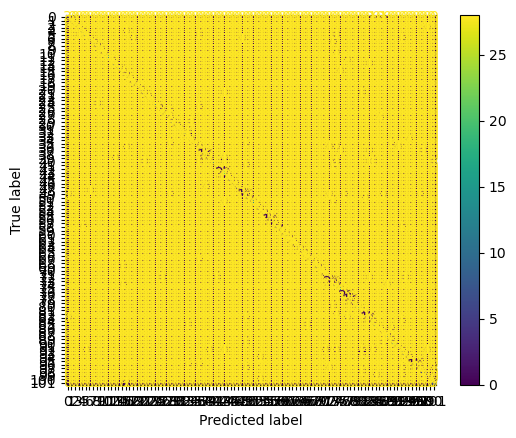

normalized confusion matrix
[[0.6        0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.4        0.         0.        ]
 [0.         0.         0.         ... 0.         0.75       0.        ]
 [0.         0.         0.         ... 0.         0.         0.85714286]]


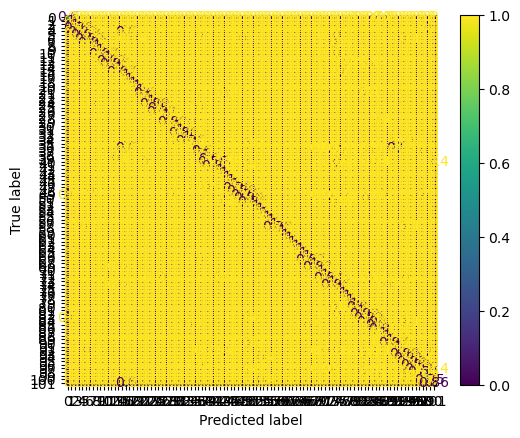

In [11]:
# Please plot the confusion matrix other than print() if possible
from sklearn.metrics import confusion_matrix as conf_mat
from sklearn.metrics import ConfusionMatrixDisplay

import numpy as np
cf =conf_mat(label_data,predictions)
subsample = 10

print(f'First {subsample} classes confusion matrix')
cmd_obj = ConfusionMatrixDisplay(cf[:subsample, :subsample])
cmd_obj.plot()
plt.show()

# normalized confusion matrix
print(f'First {subsample} classes normalized confusion matrix')
ncf = cf / np.sum(cf, axis=1)
cmd_obj = ConfusionMatrixDisplay(ncf[:subsample, :subsample])
cmd_obj.plot()
plt.show()

print('confusion matrix')
print(cf)
cmd_obj = ConfusionMatrixDisplay(cf)
cmd_obj.plot()
plt.show()

# normalized confusion matrix
print('normalized confusion matrix')
ncf = cf / np.sum(cf, axis=1)
print(ncf)
cmd_obj = ConfusionMatrixDisplay(ncf)
cmd_obj.plot()
plt.show()

### *Question 10: Transfer Learning*
- What is the purpose of a pretrained model and why should it work?
#### - The purpose of the pretrained model is to reduce the training time required.  The concept behind using it is that the early layers are already trained to find basic features in an image, and therefore it is unneccesary to retrain those nodes.
- Why should we freeze the features' gradient in the pretrained model but only update the classifier?
#### - If we did not freeze these layers, we would update features, which negates the purpose of using a pre-trained model to start with.
- What may happen if we do not freeze the features' gradient?
#### - if we did not freeze the features' gradient, we would need to train longer, as the first batches of the first epoch would make relativelt large changes to the pretrained weights assigned.